In [1]:
!pip install deepd3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.0/961.0 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 100.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.1 MB/s eta 0:00:00


In [4]:
# Neural network libraries

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
# import segmentation_models as sm
# sm.set_framework("tf.keras")

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# DeepD3
from deepd3.model import DeepD3_Model
from deepd3.training.stream import DataGeneratorStream

In [ ]:
TRAINING_DATA_PATH = r"/content/DeepD3_Training.d3set"
VALIDATION_DATA_PATH = r"/content/DeepD3_Validation (1).d3set"

dg_training = DataGeneratorStream(TRAINING_DATA_PATH,
                                  batch_size=32, # Data processed at once, depends on your GPU
                                  target_resolution=0.094, # fixed to 94 nm, can be None for mixed resolution training
                                  min_content=50) # images need to have at least 50 segmented px

dg_validation = DataGeneratorStream(VALIDATION_DATA_PATH,
                                    batch_size=32,
                                    target_resolution=0.094,
                                    min_content=50,
                                    augment=False,
                                    shuffle=False)

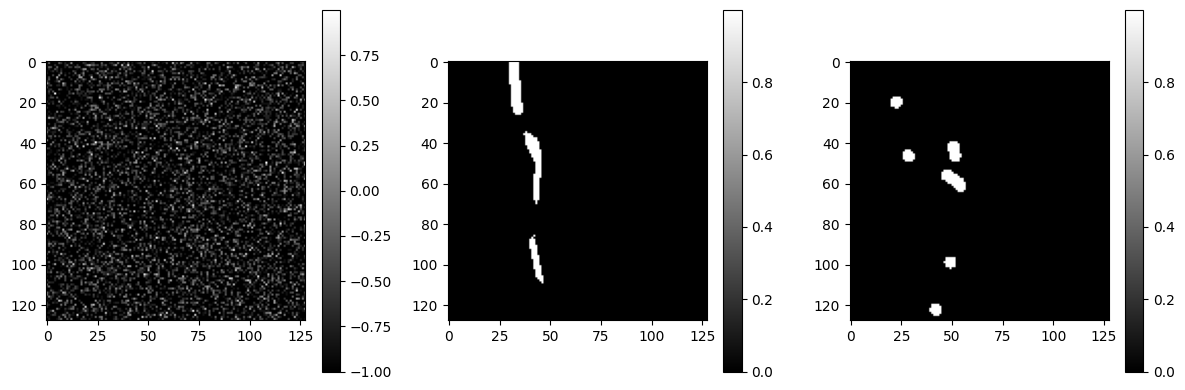

In [ ]:
X, Y = dg_training[0]
i = 0

plt.figure(figsize=(12,4))

plt.subplot(131)
plt.imshow(X[i].squeeze(),cmap='gray')
plt.colorbar()

plt.subplot(132)
plt.imshow(Y[0][i].squeeze(),cmap='gray')
plt.colorbar()

plt.subplot(133)
plt.imshow(Y[1][i].squeeze(),cmap='gray')
plt.colorbar()

plt.tight_layout()

In [ ]:
# Create a naive DeepD3 model with a given base filter count (e.g. 32)
m = DeepD3_Model(filters=32,input_shape=(384, 1472, 1))
from keras import losses
# Set appropriate training settings
m.compile(Adam(learning_rate=0.0005),
          loss='mean_squared_error',# optimizer, good default setting, can be tuned
          # [sm.losses.dice_loss, "mse"], # Dice loss for dendrite, MSE for spines
          metrics=['acc']
          ) # Metrics for monitoring progress

m.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 384, 1472,   0           []                               
                                1)]                                                               
                                                                                                  
 enc_layer0_conv1 (Conv2D)      (None, 384, 1472, 3  288         ['input[0][0]']                  
                                2)                                                                
                                                                                                  
 enc_layer0_conv1_BN (BatchNorm  (None, 384, 1472, 3  128        ['enc_layer0_conv1[0][0]']       
 alization)                     2)                                                          

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler

In [ ]:
def schedule(epoch, lr):
    if epoch < 15:
        return lr

    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
EPOCHS = 20

# Save best model automatically during training
mc = ModelCheckpoint("DeepD3_model.h5",
                            save_best_only=True)

# Save metrics
csv = CSVLogger("DeepD3_model.csv")

# Adjust learning rate during training to allow for better convergence
lrs = LearningRateScheduler(schedule)

# Actually train the network
h = m.fit(dg_training,
        batch_size=32,
        epochs=EPOCHS,
        validation_data=dg_validation,
        callbacks=[mc, csv, lrs])

Epoch 1/20
1562/1562 [==============================] - 806s 498ms/step - loss: 0.0448 - dendrites_loss: 0.0209 - spines_loss: 0.0239 - dendrites_acc: 0.9765 - spines_acc: 0.9787 - val_loss: 0.0378 - val_dendrites_loss: 0.0200 - val_spines_loss: 0.0178 - val_dendrites_acc: 0.9607 - val_spines_acc: 0.9762 - lr: 5.0000e-04
Epoch 2/20
1562/1562 [==============================] - 785s 503ms/step - loss: 0.0201 - dendrites_loss: 0.0106 - spines_loss: 0.0095 - dendrites_acc: 0.9788 - spines_acc: 0.9816 - val_loss: 0.0241 - val_dendrites_loss: 0.0132 - val_spines_loss: 0.0108 - val_dendrites_acc: 0.9648 - val_spines_acc: 0.9733 - lr: 5.0000e-04
Epoch 3/20
1562/1562 [==============================] - 778s 498ms/step - loss: 0.0184 - dendrites_loss: 0.0099 - spines_loss: 0.0086 - dendrites_acc: 0.9788 - spines_acc: 0.9816 - val_loss: 0.0242 - val_dendrites_loss: 0.0130 - val_spines_loss: 0.0112 - val_dendrites_acc: 0.9623 - val_spines_acc: 0.9732 - lr: 5.0000e-04
Epoch 4/20
1562/1562 [=========

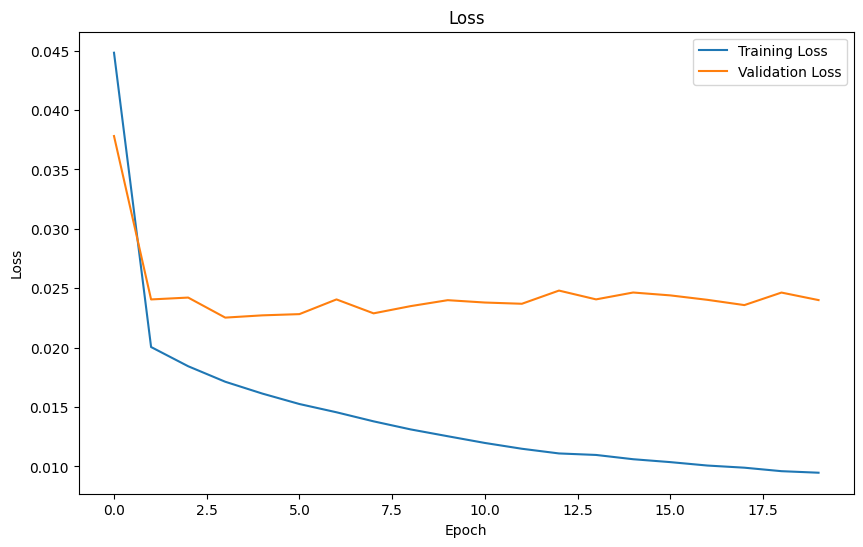

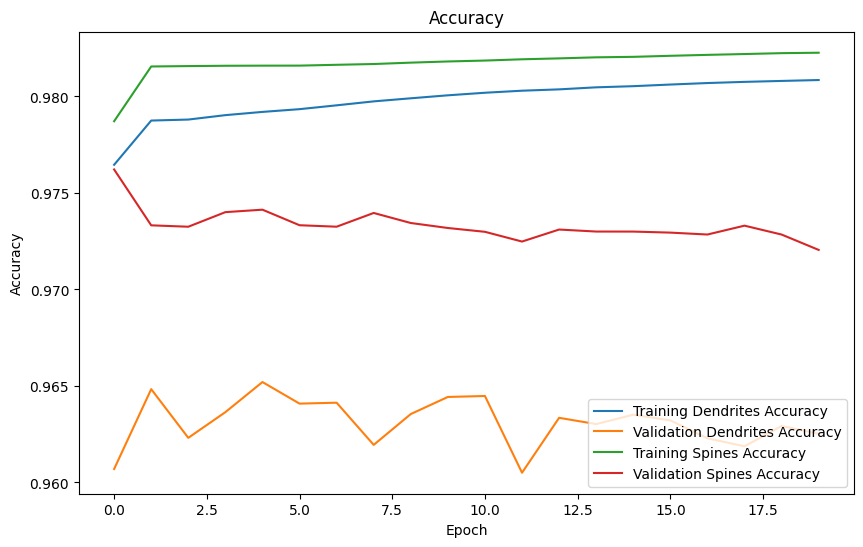

In [ ]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(10, 6))
plt.plot(h.history['loss'], label='Training Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Accuracy
plt.figure(figsize=(10, 6))
plt.plot(h.history['dendrites_acc'], label='Training Dendrites Accuracy')
plt.plot(h.history['val_dendrites_acc'], label='Validation Dendrites Accuracy')
plt.plot(h.history['spines_acc'], label='Training Spines Accuracy')
plt.plot(h.history['val_spines_acc'], label='Validation Spines Accuracy')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()


In [ ]:
!pip install flammkuchen


In [29]:
import flammkuchen as fl
import numpy as np
from deepd3.core.analysis import Stack

from tensorflow.keras.models import load_model
pred_fn = "predictions.blosc"

# need to change the custom model bcoz of this model" is incompatible with the layer: expected shape=(None, 128, 128, 1), found shape=(None, 384, 1472, 1
# Specify the filepath to the saved model
# model_fn = "/content/DeepD3_model.h5"  # Replace with the actual filepath
model_fn = "//content/DeepD3_8F_94nm.h5"
# model_fn.summary()
# Load the model from the filepath
model = load_model(model_fn, compile=False)
# model.summary()
# Load the input data or stack
stack = Stack('/content/DeepD3_Benchmark.tif')

stack.predictWholeImage(model_fn)

# Generate predictions using the loaded model
#predictions = model.predict(stack)

# Save the predictions
#fl.save('predictions.flam', {'predictions': predictions}, compression='blosc')
fl.save(pred_fn,
            dict(dendrites=stack.prediction[...,0].astype(np.float32),
                spines=stack.prediction[..., 1].astype(np.float32)),
                compression='blosc')

  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 8s 8s/step


  1%|▏         | 1/71 [00:10<12:47, 10.96s/it]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 2/71 [00:11<05:15,  4.58s/it]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 3/71 [00:11<02:52,  2.54s/it]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 4/71 [00:11<01:45,  1.58s/it]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 5/71 [00:11<01:09,  1.05s/it]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 6/71 [00:11<00:47,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 7/71 [00:11<00:33,  1.90it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 8/71 [00:11<00:24,  2.55it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 9/71 [00:11<00:18,  3.31it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 10/71 [00:11<00:14,  4.15it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 11/71 [00:12<00:11,  5.04it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 12/71 [00:12<00:10,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 13/71 [00:12<00:09,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 14/71 [00:12<00:08,  6.90it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 15/71 [00:12<00:07,  7.54it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 16/71 [00:12<00:06,  8.04it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 17/71 [00:12<00:06,  7.97it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 18/71 [00:12<00:06,  8.44it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 19/71 [00:12<00:05,  8.83it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 20/71 [00:13<00:05,  9.06it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 21/71 [00:13<00:05,  8.98it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 22/71 [00:13<00:05,  8.75it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 23/71 [00:13<00:05,  8.99it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 24/71 [00:13<00:05,  9.07it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 25/71 [00:13<00:04,  9.28it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 26/71 [00:13<00:04,  9.45it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 27/71 [00:13<00:04,  8.97it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 28/71 [00:13<00:05,  8.22it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 29/71 [00:14<00:05,  7.70it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 30/71 [00:14<00:05,  7.34it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 31/71 [00:14<00:05,  7.51it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 32/71 [00:14<00:05,  7.42it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 33/71 [00:14<00:05,  7.59it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 34/71 [00:14<00:04,  7.72it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 35/71 [00:14<00:04,  7.73it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 36/71 [00:15<00:04,  7.84it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 37/71 [00:15<00:04,  7.87it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▎    | 38/71 [00:15<00:04,  7.52it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 39/71 [00:15<00:04,  7.20it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▋    | 40/71 [00:15<00:04,  6.87it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 41/71 [00:15<00:04,  6.82it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 42/71 [00:15<00:04,  6.87it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 43/71 [00:16<00:04,  6.85it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 44/71 [00:16<00:03,  6.83it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 45/71 [00:16<00:03,  7.14it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 46/71 [00:16<00:03,  7.33it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 47/71 [00:16<00:03,  7.79it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 48/71 [00:16<00:02,  7.84it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 49/71 [00:16<00:02,  8.33it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 50/71 [00:16<00:02,  8.32it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 51/71 [00:17<00:02,  8.33it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 52/71 [00:17<00:02,  8.57it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 53/71 [00:17<00:02,  8.41it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 54/71 [00:17<00:01,  8.68it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 55/71 [00:17<00:01,  8.83it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 56/71 [00:17<00:01,  8.64it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 57/71 [00:17<00:01,  8.38it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 58/71 [00:17<00:01,  8.31it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 59/71 [00:17<00:01,  8.69it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 60/71 [00:18<00:01,  8.47it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 61/71 [00:18<00:01,  8.83it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 62/71 [00:18<00:01,  8.88it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 63/71 [00:18<00:00,  8.55it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 64/71 [00:18<00:00,  8.36it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 65/71 [00:18<00:00,  8.68it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 66/71 [00:18<00:00,  8.87it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 67/71 [00:18<00:00,  9.02it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 68/71 [00:18<00:00,  9.13it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 69/71 [00:19<00:00,  9.06it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 70/71 [00:19<00:00,  9.10it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 71/71 [00:19<00:00,  3.68it/s]


In [19]:
import numpy as np
from PyQt5.QtCore import QObject, pyqtSignal
import imageio as io
import flammkuchen as fl
import os
import cv2
from skimage.measure import find_contours, moments
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.draw import disk
from tqdm import tqdm
import cc3d
from numba import njit
from deepd3.core.dendrite import sphere
from scipy.ndimage import grey_closing, binary_dilation, label as labelImage, distance_transform_edt


In [33]:
# @njit(cache=True)
def _get_sorted_seeds(stack, threshold=0.8):
    """Sort seeds according to their highest prediction value

    Args:
        stack (numpy ndarray): The stack with the predictions
        threshold (float, optional): The threshold for being a seed pixel. Defaults to 0.8.

    Returns:
        numpy.ndarray: seed coordinates sorted by prediction value
    """
    coords = np.nonzero(stack>=threshold)
    intensities = stack[coords]
    # Highest peak first
    idx_maxsort = np.argsort(-intensities)
    coords = np.transpose(coords)[idx_maxsort]
    return coords

In [31]:
@njit
def _distance_to_seed(seed, pos, delta_xy = 1, delta_z = 1):
    """Computes the euclidean distance between seed pixel and current position `pos`

    Args:
        seed (tuple): seed pixel coordinates (x,y,z)
        pos (tuple): current position coordinates (x,y,z)

    Returns:
        float: euclidean distance between seed and current position
    """
    a = (seed[0] * delta_xy - pos[0] * delta_xy)**2
    b = (seed[1] * delta_xy - pos[1] * delta_xy)**2
    c = (seed[2] * delta_z  - pos[2] * delta_z)**2

    return np.sqrt(a+b+c)

In [34]:
@njit
def connected_components_3d(prediction, seeds, delta, threshold, distance, dimensions):
    """Computes connected components in 3D using various constraints.
    Each ROI is grown from a seed pixel. From there, in a 26-neighbour fashion more
    pixels are added iteratively. Each additional pixel needs to fulfill the following requirements:

    * The new pixel's intensity needs to be in a given range relative to the seed intensity (`delta`)
    * The new pixel's intensity needs to be above a given `threshold`
    * The new pixel's position needs to be in the vicinity (`distance`) of the seed pixel

    Each pixel can only be assigned to one ROI once.

    Args:
        prediction (numpy.ndarray): prediction from deep neural network
        seeds (numpy.ndarray): seed pixels
        delta (float): difference to seed pixel intensity
        threshold (float): threshold for pixel intensity
        distance (int or float): maximum euclidean distance in microns to seed pixel
        dimensions (dict(float, float)): xy and z pitch in microns

    Returns:
        tuple(labels, N): the labelled stack and the number of found ROIs
    """
    # Initialize everything as background
    im = np.zeros(prediction.shape, dtype=np.uint16)
    L = 1 # Start with label 1

    delta_xy = dimensions[0]
    delta_z  = dimensions[1]

    # Iterate through seed pixels
    for i in range(seeds.shape[0]):
        # Retrieve location and seed intensity
        x0, y0, z0 = seeds[i]
        t = prediction[x0, y0, z0]

        # Seed pixel has been assigned to a label already, skip
        if im[x0, y0, z0]:
            continue

        # Start with the floodfilling
        neighbours = [(x0, y0, z0)]

        while len(neighbours):
            # Look at next pixel
            x, y, z = neighbours.pop()

            # Current pixel not in stack
            if x >= im.shape[0] or x < 0:
                continue

            if y >= im.shape[1] or y < 0:
                continue

            if z >= im.shape[2] or z < 0:
                continue

            # Intensity at given point
            p0 = prediction[x, y, z]

            # A good pixel should be
            # - similar to the seed px (delta)
            # - intensity above a given threshold
            # - in label image it is still a background px
            # - distance to seed is lower than distance
            if abs(p0 - t) <= delta * t and \
                 p0 > threshold and \
                 im[x, y, z] == 0 and \
                 _distance_to_seed((x0, y0, z0), (x,y,z), delta_xy, delta_z) < distance:

                # Assign pixel current label
                im[x,y,z] = L

                # Look at neighbours
                neighbours.extend(_neighbours(x,y,z))

        # Finished with this label
        L += 1

    return im, L-1

In [28]:
# !pip install PyQt
from PyQt5.QtCore import QObject, pyqtSignal
class ROI3D_Creator(QObject):
    zSignal = pyqtSignal(int, int)
    log = pyqtSignal(str)

    def __init__(self, dendrite_prediction, spine_prediction, mode='floodfill', areaThreshold=0.25,
        peakThreshold=0.8, seedDelta=0.1, distanceToSeed=10, dimensions=dict(xy=0.094, z=0.5)):
        """3D ROI Creator.

        Given the arguments, 3D ROIs are built dynamically from dendrite and spine prediction.

        Args:
            dendrite_prediction (numpy.ndarray): dendrite prediction probability stack
            spine_prediction (numpy.ndarray): spine prediction probability stack
            mode (str, optional): Mode for building 3D rois (floodfill or connected components). Defaults to 'floodfill'.
            areaThreshold (float, optional): Area threshold for floodfilling and connected components. Defaults to 0.25.
            peakThreshold (float, optional): Peak threshold for finding seed points. Defaults to 0.8.
            seedDelta (float, optional): Difference to seed in terms of relative probability. Defaults to 0.1.
            distanceToSeed (int, optional): Distance to seed px in micrometer. Defaults to 10.
            dimensions (dict, optional): Dimensions in xy and z in in micrometer. Defaults to dict(xy=0.094, z=0.5).
        """

        super().__init__()
        self.dendrite_prediction = dendrite_prediction
        self.spine_prediction = spine_prediction
        self.mode = mode # floodfill or thresholded
        self.areaThreshold = areaThreshold
        self.peakThreshold = peakThreshold
        self.seedDelta = seedDelta
        self.distanceToSeed = distanceToSeed
        self.dimensions = dimensions
        self.roi_map = np.zeros_like(spine_prediction, dtype=np.int32)
        self.rois = {}

        self.computeContours = True

    def create(self, minPx, maxPx, minPlanes, applyWatershed=False, dilation=0):
        """Create 3D ROIs

        Args:
            minPx (int): only retain 3D ROIs containing at least `minPx` pixels
            maxPx (int): only retain 3D ROIs containing at most `maxPx` pixels
            minPlanes (int): only retain 3D ROIs spanning at least `minPlanes` planes
            applyWatershed (bool, optional): Apply watershed algorithm to divide ROIs. Defaults to False.
            dilation (int, optional): Dilate dendrite probability map. Defaults to 0.

        Returns:
            int: number of retained ROIs
        """
        ROI_id = 0

        # Find raw labels
        self.log.emit("Create labels")

        if self.mode == 'floodfill':
            # Find all potential seed pixels that are at least at peakThreshold
            seeds = _get_sorted_seeds(self.spine_prediction, self.peakThreshold)

            # Generate all labels using custom 3D connected components
            labels, N = connected_components_3d(self.spine_prediction,
                seeds,
                self.seedDelta,
                self.areaThreshold,
                self.distanceToSeed,
                (self.dimensions['xy'], self.dimensions['z']))

        else:
            thresholded_im = self.spine_prediction > self.areaThreshold

            if dilation > 0:
                thresholded_im = binary_dilation(thresholded_im, np.ones((3,3,3)), iterations=dilation)

            labels, N = cc3d.connected_components(thresholded_im, return_N=True)

        if applyWatershed:
            D = distance_transform_edt(labels > 0)
            # Seed generation
            localMax = peak_local_max(D, indices=False, min_distance=0, footprint=np.ones((3,3,3)), exclude_border=1)

            markers = labelImage(localMax, structure=np.ones((3,3,3)))[0]

                                        ### data # seeds   # eliminate noise
            labels = watershed(-D, markers, mask=labels > 0)

        self.log.emit("Compute meta data")
        # Compute raw centroids, check size and plane span of ROIs
        cs, px, planes = centroids3D_from_labels(labels)
        planes = planes.sum(1)


        self.log.emit("Clean ROIs")
        # Find ROIs that do not match the criteria
        criteria_mismatch = (planes < minPlanes) | (px < minPx) | (px > maxPx)
        rois_to_delete = np.where(criteria_mismatch)[0]

        self.log.emit(f"Removing {len(rois_to_delete)} ROIs...")

        self.log.emit("Clean labels")
        # Clean all labels
        labels = cleanLabels(labels, rois_to_delete)
        labels = reid(labels)

        # Re-compute information
        cs, px, planes = centroids3D_from_labels(labels)
        planes = planes.sum(1)

        # Compute the centroids again after cleaning the labels
        centroids = cs/px[:, None]

        self.roi_centroids = centroids

        if self.computeContours:

            self.log.emit("Compute contours and create plane-wise slices")
            for z in tqdm(range(self.spine_prediction.shape[0])):
                self.rois[z] = []
                labels_plane = labels[z]

                # Compute contours...
                for ROI_id in np.unique(labels_plane):
                    if ROI_id == 0:
                        continue

                    c = find_contours(labels_plane==ROI_id)
                    self.rois[z].append({
                        'ROI_id': ROI_id,
                        'contour': c[0],
                        'centroid': np.asarray(centroids[ROI_id])
                    })

                # Talk to progress bar
                self.zSignal.emit(z, self.spine_prediction.shape[0])

        self.roi_map = labels
        self.log.emit("Done.")
        return np.max(labels)

In [21]:
def _neighbours(x,y,z):
    """Generates 26-connected neighbours

    Args:
        x (int): x-value
        y (int): y-value
        z (int): z-value

    Returns:
        list: neighbour indices of a given point (x,y,z)
    """
    look = []

    for i in range(x-1, x+2):
        for j in range(y-1, y+2):
            for k in range(z-1, z+2):
                if not (i == x and j == y and k == z):
                    look.append((i,j,k))

    return look

In [22]:
def cleanLabels(labels, rois_to_delete):
    """Cleans labels from label stack. Set labels in rois_to_delete to background.

    Args:
        labels ([type]): [description]
        rois_to_delete ([type]): [description]

    Returns:
        [type]: [description]
    """
    clean_labels = np.zeros(labels.shape, dtype=np.int32)

    # Iterate through stack
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            for k in range(labels.shape[2]):
                l = labels[i,j,k]

                # If it is background label, go on
                if l == 0:
                    continue

                # Not background label, check if label should remain
                if (rois_to_delete==l).sum() > 0:
                    clean_labels[i,j,k] = 0

                else:
                    clean_labels[i,j,k] = l

    return clean_labels

In [23]:
def reid(labels):
    """Relabel an existing label map to ensure continuous label ids

    Args:
        labels (numpy.ndarray): original label map

    Returns:
        numpy.ndarray: re-computed label map
    """
    ls = np.unique(labels)

    new_labels = np.zeros(labels.shape, dtype=np.int32)

    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            for k in range(labels.shape[2]):
                l = labels[i,j,k]

                if l == 0:
                    continue

                else:
                    new_labels[i,j,k] = np.argmax(ls==l)

    return new_labels

In [24]:
def centroids3D_from_labels(labels):
    """Computes the centroid for each label in an 3D stack containing image labels.
    0 is background, 1...N are foreground labels.
    This function uses image moments to compute the centroid.

    Args:
        labels (numpy.ndarray): ROI labeled image (0...N)

    Returns:
        tuple(numpy.ndarray, numpy.ndarray, numpy.ndarray):
            Returns first-order moments, zero-order moments and covered planes
    """
    N = np.max(labels)
    # First-order moments for z, y, and x
    cs = np.zeros((N+1, 3), dtype=np.float32)
    # Zero-order moment (area/mass of label)
    px = np.zeros(N+1, dtype=np.float32)
    # Coverage of planes (ROIs x z-planes)
    planes = np.zeros((N+1, labels.shape[0]), dtype=np.int32)

    # Fast for-loops using numba
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            for k in range(labels.shape[2]):
                l = labels[i,j,k]
                cs[l, 0] += i # M 1,0,0
                cs[l, 1] += j # M 0,1,0
                cs[l, 2] += k # M 0,0,1
                px[l] += 1    # M 0,0,0
                planes[l,i] = 1 # plane coverage

    return cs, px, planes

In [ ]:
# import networkx as nx
# from scipy.ndimage import binary_opening, binary_closing, binary_erosion, binary_dilation
# from skimage.measure import label, regionprops
# from skimage.segmentation import relabel_sequential
# # !pip install PyQt
# class ROI3D_Creator(QObject):
#     zSignal = pyqtSignal(int, int)
#     log = pyqtSignal(str)

#     def __init__(self, dendrite_prediction, spine_prediction, mode='floodfill', areaThreshold=0.25,
#         peakThreshold=0.8, seedDelta=0.1, distanceToSeed=10, dimensions=dict(xy=0.094, z=0.5)):
#         """3D ROI Creator.

#         Given the arguments, 3D ROIs are built dynamically from dendrite and spine prediction.

#         Args:
#             dendrite_prediction (numpy.ndarray): dendrite prediction probability stack
#             spine_prediction (numpy.ndarray): spine prediction probability stack
#             mode (str, optional): Mode for building 3D rois (floodfill or connected components). Defaults to 'floodfill'.
#             areaThreshold (float, optional): Area threshold for floodfilling and connected components. Defaults to 0.25.
#             peakThreshold (float, optional): Peak threshold for finding seed points. Defaults to 0.8.
#             seedDelta (float, optional): Difference to seed in terms of relative probability. Defaults to 0.1.
#             distanceToSeed (int, optional): Distance to seed px in micrometer. Defaults to 10.
#             dimensions (dict, optional): Dimensions in xy and z in in micrometer. Defaults to dict(xy=0.094, z=0.5).
#         """

#         super().__init__()
#         self.dendrite_prediction = dendrite_prediction
#         self.spine_prediction = spine_prediction
#         self.mode = mode # floodfill or thresholded
#         self.areaThreshold = areaThreshold
#         self.peakThreshold = peakThreshold
#         self.seedDelta = seedDelta
#         self.distanceToSeed = distanceToSeed
#         self.dimensions = dimensions
#         self.roi_map = np.zeros_like(spine_prediction, dtype=np.int32)
#         self.rois = {}

#         self.computeContours = True

#     def create(self, minPx, maxPx, minPlanes, applyWatershed=False, dilation=0):
#         """Create 3D ROIs

#         Args:
#             minPx (int): only retain 3D ROIs containing at least `minPx` pixels
#             maxPx (int): only retain 3D ROIs containing at most `maxPx` pixels
#             minPlanes (int): only retain 3D ROIs spanning at least `minPlanes` planes
#             applyWatershed (bool, optional): Apply watershed algorithm to divide ROIs. Defaults to False.
#             dilation (int, optional): Dilate dendrite probability map. Defaults to 0.

#         Returns:
#             int: number of retained ROIs
#         """
#         ROI_id = 0

#         # Find raw labels
#         self.log.emit("Create labels")
#            # Construct graph from prediction
#         G = self._construct_graph(self.spine_prediction)

#         # Get connected components
#         components = list(nx.connected_components(G))

#         # Construct labels from connected components
#         labels = self._components_to_labels(components, self.spine_prediction.shape)

#         # if self.mode == 'floodfill':
#         #     # Find all potential seed pixels that are at least at peakThreshold
#         #     seeds = _get_sorted_seeds(self.spine_prediction, self.peakThreshold)

#         #     # Generate all labels using custom 3D connected components
#         #     labels, N = connected_components_3d(self.spine_prediction,
#         #         seeds,
#         #         self.seedDelta,
#         #         self.areaThreshold,
#         #         self.distanceToSeed,
#         #         (self.dimensions['xy'], self.dimensions['z']))

#         # else:
#         #     thresholded_im = self.spine_prediction > self.areaThreshold

#         #     if dilation > 0:
#         #         thresholded_im = binary_dilation(thresholded_im, np.ones((3,3,3)), iterations=dilation)

#         #     labels, N = cc3d.connected_components(thresholded_im, return_N=True)

#         # if applyWatershed:
#         D = distance_transform_edt(labels > 0)
#             # Seed generation
#         localMax = peak_local_max(D, indices=False, min_distance=0, footprint=np.ones((3,3,3)), exclude_border=1)

#         markers = labelImage(localMax, structure=np.ones((3,3,3)))[0]

#                                         ### data # seeds   # eliminate noise
#         labels = watershed(-D, markers, mask=labels > 0)
#         #######refeine and morphological operations########
#         properties = regionprops(labels, self.spine_prediction)  # compute properties of ROIs
#         valid_labels = []
#         for prop in properties:
#             if minPx < prop.area < maxPx and prop.mean_intensity > self.peakThreshold:
#                 valid_labels.append(prop.label)

#         valid_labels_mask = np.isin(labels, valid_labels)
#         labels = labels * valid_labels_mask  # discard ROIs not in valid_labels

#     # Merging overlapping or adjacent ROIs can be achieved by dilation and erosion operations
#     # (also known as opening operation)
#         if dilation > 0:
#             labels = binary_dilation(labels, structure=np.ones((3, 3, 3)), iterations=dilation)
#             labels = label(labels)  # relabel after dilation
#         labels = binary_erosion(labels, structure=np.ones((3, 3, 3)), iterations=dilation)

#     # You can use the closing operation to fill small holes or connect disjoint parts
#         labels = binary_closing(labels, structure=np.ones((3, 3, 3)), iterations=dilation)

#         labels, _, _ = relabel_sequential(labels)

#     # Recalculate ROI properties after refinement
#         #############################################
#         self.log.emit("Compute meta data")
#         # Compute raw centroids, check size and plane span of ROIs
#         cs, px, planes = centroids3D_from_labels(labels)
#         planes = planes.sum(1)


#         self.log.emit("Clean ROIs")
#         # Find ROIs that do not match the criteria
#         criteria_mismatch = (planes < minPlanes) | (px < minPx) | (px > maxPx)
#         rois_to_delete = np.where(criteria_mismatch)[0]

#         self.log.emit(f"Removing {len(rois_to_delete)} ROIs...")

#         self.log.emit("Clean labels")
#         # Clean all labels
#         labels = cleanLabels(labels, rois_to_delete)
#         labels = reid(labels)

#         # Re-compute information
#         cs, px, planes = centroids3D_from_labels(labels)
#         planes = planes.sum(1)

#         # Compute the centroids again after cleaning the labels
#         centroids = cs/px[:, None]

#         self.roi_centroids = centroids

#         if self.computeContours:

#             self.log.emit("Compute contours and create plane-wise slices")
#             for z in tqdm(range(self.spine_prediction.shape[0])):
#                 self.rois[z] = []
#                 labels_plane = labels[z]

#                 # Compute contours...
#                 for ROI_id in np.unique(labels_plane):
#                     if ROI_id == 0:
#                         continue

#                     c = find_contours(labels_plane==ROI_id)
#                     self.rois[z].append({
#                         'ROI_id': ROI_id,
#                         'contour': c[0],
#                         'centroid': np.asarray(centroids[ROI_id])
#                     })

#                 # Talk to progress bar
#                 self.zSignal.emit(z, self.spine_prediction.shape[0])

#         self.roi_map = labels
#         self.log.emit("Done.")
#         return np.max(labels)

#     def _construct_graph(self, prediction):
#         """Construct a graph from a 3D volume.

#         Args:
#             prediction (numpy.ndarray): 3D volume

#         Returns:
#             networkx.Graph: Graph representation of the volume
#         """
#         G = nx.Graph()

#         # Iterate over voxels in the volume
#         for index, value in np.ndenumerate(prediction):
#             # If voxel value is above the threshold, add it to the graph
#             if value > self.areaThreshold:
#                 G.add_node(index)

#         # Iterate over edges in the graph
#         for node in G.nodes:
#             # Add edges to neighbors in 3D
#             neighbors = _neighbours(*node)
#             for neighbor in neighbors:
#                 if neighbor in G.nodes:
#                     G.add_edge(node, neighbor)

#         return G

#     def _components_to_labels(self, components, shape):
#         """Convert connected components to a label volume.

#         Args:
#             components (list): List of connected components
#             shape (tuple): Shape of the output volume

#         Returns:
#             numpy.ndarray: Label volume
#         """
#         labels = np.zeros(shape, dtype=np.uint16)

#         for label, component in enumerate(components, start=1):
#             for voxel in component:
#                 labels[voxel] = label

#         return labels


In [36]:
# Building 3D ROIs

rois_fn = "rois_old.blosc"
# rois_fn = "rois.blosc"

r = ROI3D_Creator(stack.prediction[..., 0],
            stack.prediction[..., 1],
            mode='floodfill', areaThreshold=0.25,
        peakThreshold=0.8, seedDelta=0.1, distanceToSeed=10, dimensions=dict(xy=0.094, z=0.5))

rois_labels = r.create(1,
            1390,
            3)


print("Saving ROIs...")
fl.save(rois_fn,
                dict(rois=r.rois, roi_map=r.roi_map),
                compression='blosc')

TypingError: ignored

In [ ]:
import flammkuchen as fl
# Load the saved file
data_roi = fl.load('/content/rois.blosc')

# Access the saved data
rois = data_roi['rois']

# Print the contents of rois
print("ROIs:")
print(rois)

import pandas as pd
# Create empty lists to store the extracted data
roi_ids = []
contour_points = []
centroids = []

# # Extract the data from the list of dictionaries
# for roi in rois_old:
#     roi_ids.append(roi['ROI_id'])
#     contour_points.append(roi['contour'])
#     centroids.append(roi['centroid'])

# # Create a DataFrame
# df = pd.DataFrame({'ROI_id': roi_ids, 'contour': contour_points, 'centroid': centroids})


for k, v in rois.items():
  for i in v:
    roi_ids.append(i['ROI_id'])
    contour_points.append(i['contour'])
        # Assuming the centroid is a sequence of numerical values
    centroids.append([round(num, 5) for num in i['centroid']])
    # centroids.append(i['centroid'])



# Export the DataFrame to a CSV file

df = pd.DataFrame({'ROI_id': roi_ids, 'contour': contour_points, 'centroid': centroids})
df.to_csv('/content/roi_custom.csv', index=False)

ROIs:


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
import pandas as pd

# Load the CSV file
data = pd.read_csv('/content/roi_custom.csv')

# Extract numerical items from the "centroid" column
items = data['centroid'].str.extract(r'\[\s*([\d.]+),\s*([\d.]+),\s*([\d.]+)\s*\]')

# Create new columns for x, y, and z
data['Pos'] = items[0].astype(float)
data['Y'] = items[1].astype(float)
data['X'] = items[2].astype(float)

# Round to 5 decimal places
data['Pos'] = data['Pos'].round(5)
data['Y'] = data['Y'].round(5)
data['X'] = data['X'].round(5)

# Save the modified dataframe to the CSV file
data.to_csv('new_roidata.csv', index=False)

In [ ]:
import csv
import math

scores = []  # Scores for calculating ROC curve
labels = []  # True labels for calculating ROC curve

def euclidean_distance(a, b):
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(a, b)))

threshold = 1.9

with open('/content/final_clusters.csv', 'r') as file:
    reader = csv.DictReader(file)
    human_data = list(reader)

with open('/content/new_roidata.csv', 'r') as file:
    reader = csv.DictReader(file)
    roi_data = list(reader)
tp = 0
fp = 0
fn = 0
for roi_row in roi_data:
    roi_id = roi_row['ROI_id']
    centroid = (float(roi_row['X']), float(roi_row['Y']), float(roi_row['Pos']))

    matched = False
    for human_row in human_data:
        label = human_row['label']
        human_pos = (float(human_row['X']), float(human_row['Y']), float(human_row['Pos']))

        # Compare the centroid values with the human annotated data using a distance threshold
        if euclidean_distance(centroid, human_pos) < threshold:
            matched = True
            break

    if matched:
        tp += 1
        scores.append(1)  # Positive score
        labels.append(1)  # True positive label

    else:
        fp += 1
        scores.append(0)  # Negative score
        labels.append(0)  # True negative label


print(len(scores))
print(len(labels))
# Count the false negatives by subtracting the matched true positives from the total number of human annotations
fn = len(human_data) - tp
recall = tp / (tp + fn)
precision = tp / (tp + fp)

print("Recall:", recall)
print("Precision:", precision)

f1_score = 2 * (precision * recall) / (precision + recall)
print("F1 Score:", f1_score)

3706
3706
Recall: 0.9697908597986057
Precision: 0.675661090124123
F1 Score: 0.7964376590330788


In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from collections import Counter

# Load the data
model_data = pd.read_csv('/content/old_roidata.csv')
human_data = pd.read_csv('/content/final_clusters.csv')

# Extract the model centroids assuming they are in the columns 'X', 'Y', 'Z'
model_centroids = model_data[['X', 'Y', 'Pos']].values  # directly to numpy array

# Group the human data by rater and convert to list of centroid for each group
human_data['centroid'] = human_data[['X', 'Y', 'Pos']].values.tolist()  # Adjust these columns to match your data
human_centroids = human_data.groupby('Rater')['centroid'].apply(list)

# Define tolerance
tolerance = 4.5  # for example

TP = 0
FP = 0

# Iterate over model predictions
for model_centroid in model_centroids:
    # Store whether each human rater agrees with the model prediction
    rater_agreements = []

    # Check each human rater
    for rater, centroids in human_centroids.iteritems():
        # Compute distances from this rater's centroids to the model prediction
        distances = pairwise_distances([model_centroid], centroids)

        # If the minimum distance is within the tolerance, this rater agrees
        rater_agreements.append(distances.min() < tolerance)

    # Count agreements and disagreements
    agreement_counts = Counter(rater_agreements)

    # If the majority agree, it's a true positive, otherwise it's a false positive
    if agreement_counts[True] > agreement_counts[False]:
        TP += 1
    else:
        FP += 1

# Now let's compute false negatives. For this, we'll have to compare in the other direction.
FN = 0

# Iterate over human centroids
for rater, centroids in human_centroids.iteritems():
    for human_centroid in centroids:
        # Compute distances from this human centroid to the model predictions
        distances = pairwise_distances([human_centroid], model_centroids)

        # If no model prediction is within the tolerance, it's a false negative
        if distances.min() >= tolerance:
            FN += 1

# Calculate precision and recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)

print(f'Precision: {precision}, Recall: {recall}')


Streaming output truncated to the last 5000 lines.
<ipython-input-18-42537a5d4a20>:29: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for rater, centroids in human_centroids.iteritems():
<ipython-input-18-42537a5d4a20>:29: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for rater, centroids in human_centroids.iteritems():
<ipython-input-18-42537a5d4a20>:29: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for rater, centroids in human_centroids.iteritems():
<ipython-input-18-42537a5d4a20>:29: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for rater, centroids in human_centroids.iteritems():
<ipython-input-18-42537a5d4a20>:29: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for rater, centroids in human_centroids.iterite

Precision: 0.884536685179772, Recall: 0.7753010504739943


In [ ]:
# import pandas as pd
# import numpy as np

# # Load the data
# deepd3_df = pd.read_csv('/content/new_roidata.csv')
# human_df = pd.read_csv('/content/final_clusters.csv')

# # Euclidean distance function
# def euclidean_distance(point1, point2):
#     return np.sqrt(np.sum((point1 - point2) ** 2))

# # Define the distance threshold
# threshold = 1  # replace with an appropriate value

# raters = human_df['Rater'].unique()
# rater_precision = []
# rater_recall = []

# for rater in raters:
#     # Initialize counts
#     TP = 0
#     FP = 0
#     FN = 0

#     rater_df = human_df[human_df['Rater'] == rater]

#     # Loop over each point in the DeepD3 data
#     for deepd3_point in deepd3_df[['X', 'Y', 'Pos']].values:
#         # Check for a match in the rater data
#         matches = rater_df[rater_df.apply(lambda row: euclidean_distance(row[['X', 'Y', 'Pos']], deepd3_point) <= threshold, axis=1)]
#         if len(matches) > 0:
#             TP += 1
#         else:
#             FP += 1

#     # Count the False Negatives
#     for human_point in rater_df[['X', 'Y', 'Pos']].values:
#         matches = deepd3_df[np.linalg.norm(deepd3_df[['X', 'Y', 'Pos']].values - human_point, axis=1) <= threshold]
#         if len(matches) == 0:
#             FN += 1

#     # Calculate precision and recall
#     precision = TP / (TP + FP)
#     recall = TP / (TP + FN)

#     rater_precision.append(precision)
#     rater_recall.append(recall)

# # Average precision and recall
# avg_precision = np.mean(rater_precision)
# avg_recall = np.mean(rater_recall)

# print('Average Precision:', avg_precision)
# print('Average Recall:', avg_recall)


KeyboardInterrupt: ignored

In [ ]:
# import pandas as pd
# import numpy as np

# # Load the data
# deepd3_df = pd.read_csv('/content/new_roidata.csv')
# human_df = pd.read_csv('/content/final_clusters.csv')

# # Euclidean distance function
# def euclidean_distance(point1, point2):
#     return np.sqrt(np.sum((point1 - point2) ** 2))

# # Define the distance threshold
# threshold = 1  # replace with an appropriate value

# # Initialize counts
# TP = 0
# FP = 0
# FN = 0

# # Loop over each point in the DeepD3 data
# for deepd3_point in deepd3_df[['X', 'Y', 'Pos']].values:
#     # Check for a match in the human data
#     matches = human_df[human_df.apply(lambda row: euclidean_distance(row[['X', 'Y', 'Pos']], deepd3_point) <= threshold, axis=1)]
#     # If the number of matching raters is at least 4, it's a True Positive
#     if matches['Rater'].nunique() >= 4:
#         TP += 1
#     else:
#         FP += 1

# # Count the False Negatives
# # Group the human annotations by coordinates and filter those that are annotated by at least 4 raters
# majority_human_df = human_df.groupby(['X', 'Y', 'Pos']).filter(lambda x: x['Rater'].nunique() >= 4)
# for human_point in majority_human_df[['X', 'Y', 'Pos']].drop_duplicates().values:
#     matches = deepd3_df[np.linalg.norm(deepd3_df[['X', 'Y', 'Pos']].values - human_point, axis=1) <= threshold]
#     if len(matches) == 0:
#         FN += 1

# # Calculate precision and recall
# precision = TP / (TP + FP)
# recall = TP / (TP + FN)

# print('Precision:', precision)
# print('Recall:', recall)


KeyboardInterrupt: ignored

In [ ]:
# import csv
# import numpy as np

# def euclidean_distance(point1, point2):
#     return np.sqrt(np.sum((np.array(point1) - np.array(point2)) ** 2))

# # Define the distance threshold
# threshold = 1  # replace with an appropriate value

# deepd3_data = []
# human_data = []
# with open('/content/new_roidata.csv', 'r') as file:
#     reader = csv.DictReader(file)
#     for row in reader:
#         deepd3_data.append([float(row['X']), float(row['Y']), float(row['Pos'])])

# with open('/content/final_clusters.csv', 'r') as file:
#     reader = csv.DictReader(file)
#     for row in reader:
#         human_data.append([float(row['X']), float(row['Y']), float(row['Pos']), row['Rater']])

# # Initialize counts
# TP = 0
# FP = 0
# FN = 0
# human_data_by_coordinates = {}

# # Prepare a dictionary with keys as coordinates and values as list of Raters
# for row in human_data:
#     coordinates = tuple(row[:-1])
#     if coordinates in human_data_by_coordinates:
#         human_data_by_coordinates[coordinates].append(row[-1])
#     else:
#         human_data_by_coordinates[coordinates] = [row[-1]]

# # Loop over each point in the DeepD3 data
# for deepd3_point in deepd3_data:
#     # Check for a match in the human data
#     matches = {k: v for k, v in human_data_by_coordinates.items() if euclidean_distance(k, deepd3_point) <= threshold}
#     # If the number of matching raters is at least 4, it's a True Positive
#     if any([len(raters) >= 4 for raters in matches.values()]):
#         TP += 1
#     else:
#         FP += 1

# # Count the False Negatives
# majority_human_coordinates = [k for k, v in human_data_by_coordinates.items() if len(v) >= 4]
# for human_point in majority_human_coordinates:
#     if not any([euclidean_distance(deepd3_point, human_point) <= threshold for deepd3_point in deepd3_data]):
#         FN += 1

# # Calculate precision and recall
# precision = TP / (TP + FP)
# recall = TP / (TP + FN)

# print('Precision:', precision)
# print('Recall:', recall)


Precision: 0.0
Recall: 0.0
